In [49]:
# Goal: Estimate the oxygen mass based on the optical depth estimates
import sys, os, functools
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import astropy.constants as aconst
import astropy.units as u
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import astropy.table as table
from astropy.cosmology import Planck15 as cosmology
import seaborn
import pandas as pd

try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataloader as dataloader
import snelib19odp.const as const
import snelib19odp.analysis.oxygen as oxygen
import snelib19odp.blackbody as blackbody
import snelib19odp.specds as specds
import snelib19odp.analysis.spec_model as spec_model
import snelib19odp.gaussian as gaussian
import snelib19odp.utils as utils

In [50]:
# TODO: move those models to a common model package
MODEL_PREFIX = 'oxygen_tau_'
MODELS = {
    #'full_multiline_nlte0.1': oxygen.FitSetup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6158, 6230, 6454]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=3e-14),
    'full_multiline_nlte0.01': oxygen.FitSetup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6158, 6230, 6454]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.01,  max_extra_line_amp=3e-14),
    #'full_multiline_nlte0.05': oxygen.FitSetup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6158, 6230, 6454]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.05,  max_extra_line_amp=3e-14),
    'full_multiline_nlte0.95': oxygen.FitSetup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6158, 6230, 6454]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.95,  max_extra_line_amp=3e-14),
    'full_snglline_nlte0.01': oxygen.FitSetup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.01,  max_extra_line_amp=3e-14),
    'full_snglline_nlte0.95': oxygen.FitSetup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.95,  max_extra_line_amp=3e-14),
    #'full_line6230_nlte0.1': oxygen.FitSetup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([6230]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=3e-14)

}

sds = specds.load_dataset('SN2019odp')
SPECS = {
    'not_late': (sds['ZTF19abqwtfu_20200113_NOT_v1'], {'scale_factor': np.sqrt(2)/9.395640563324519e-18,}),
    'keck_early': (sds['ZTF19abqwtfu_20200124_Keck1_v1'], {'scale_factor': np.sqrt(2)/7.002413899090286e-18,}),
    'keck_late': (sds['ZTF19abqwtfu_20200821_Keck1_v1'], {
        'max_width': 20,
        'scale_factor': np.sqrt(2)/3.031557125203086e-18, 
        'start5577': 5520, 'stop5577': 5669, 'start6300_6364': 6150,
    })
}

SAMPLER_PARAMS = {
    'nlive_points': 5000,
    'dynesty_method': 'rwalk',
    'dynesty_pfrac': 0.2
}

def make_model(model, spec_name, no_cache=False):
    cfg = MODELS[model]
    spec, overrides = SPECS[spec_name]
    spec = spec[~np.isnan(spec['flux'])]
    params = cfg._replace(**overrides)
    
    model_name = MODEL_PREFIX + model + '_' + spec_name
    if no_cache:
        return spec_model.load_or_make(model_name, spec, 'oxygen_gaussline', params, SAMPLER_PARAMS, cache_options=set(['ignore-cache']))
    else:
        return spec_model.load_or_make(model_name, spec, 'oxygen_gaussline', params, SAMPLER_PARAMS)

In [3]:
for mod_name in MODELS.keys():
    for spec_name in SPECS.keys():
        #if spec_name != 'keck_late':
        #    continue
        print(mod_name, spec_name)
        specmod = make_model(mod_name, spec_name, no_cache=True)
        specmod.run()

0it [00:00, ?it/s]

full_multiline_nlte0.01 not_late


305543it [42:04, 121.03it/s, batch: 0 | bound: 511 | nc: 1 | ncall: 15078918 | eff(%):  2.026 | loglstar:   -inf < -303.388 <    inf | logz: -358.888 +/-  0.136 | dlogz:  0.000 >  0.010]  


	Mean: array([ 2.96189228e+00,  5.35951049e+03,  2.58882746e+01,  1.66984157e+01,
        1.60700037e+01,  8.79491609e-03, -4.71703401e-03,  1.98156146e+26,
       -4.44946750e+00,  2.42402545e+00, -2.49683866e+00,  1.92029472e-01,
        5.79060580e+00,  2.17466865e+00,  7.19192123e+00,  6.20218981e+00])
	Cov: array([[ 2.53653712e+00, -1.44843129e+03, -1.95583969e-03,
		         7.41764264e-03, -5.53447628e-02, -3.45143739e-05,
		        -1.41795872e-06, -1.71487797e+21, -1.95960401e-02,
		         6.54939253e-03, -1.39075326e-03,  1.79647887e-01,
		        -3.51456164e-03,  3.86006855e-01,  2.21477544e-03,
		         9.18755939e-03],
		       [-1.44843129e+03,  1.13605516e+06,  2.01136323e+00,
		         1.42164281e+00,  2.74558371e+01,  2.04485230e-02,
		        -2.74790185e-04,  7.85339790e+23,  2.63215617e+01,
		         2.79676870e+01,  1.78923106e+00, -1.04165925e+02,
		         5.53712823e-01, -1.92058061e+02, -4.37834642e-01,
		        -5.04429008e+00],
		       [-1.95583969e

338209it [59:23, 94.90it/s, batch: 0 | bound: 596 | nc: 1 | ncall: 17175308 | eff(%):  1.969 | loglstar:   -inf < -854.663 <    inf | logz: -916.695 +/-  0.148 | dlogz:  0.000 >  0.010]    


	Mean: array([ 2.92149326e+00,  5.46567812e+03,  2.59563808e+01,  1.70272461e+01,
        1.72039781e+01,  7.09491199e-03, -4.87898029e-03,  1.98149977e+26,
       -4.79176302e+00,  2.45301990e+00, -2.34670617e+00,  2.07063467e-01,
        5.72160818e+00,  5.46268154e+00,  7.61119374e+00,  6.50659301e+00])
	Cov: array([[ 2.26411899e+00, -1.20005925e+03,  1.55087771e-03,
		         3.04915302e-03, -2.45694320e-02,  1.77489404e-04,
		        -9.04134824e-06,  5.82260672e+21, -1.27472841e-02,
		         4.89490433e-03, -1.11968390e-03,  1.78324934e-01,
		        -3.04918901e-03,  9.50397330e-03,  1.86429221e-03,
		         1.92839782e-03],
		       [-1.20005925e+03,  8.17731426e+05, -9.20928402e-01,
		        -1.78188968e+00,  6.37317977e+00, -8.42138232e-02,
		         5.64598335e-03, -2.30847126e+24,  9.24012417e+00,
		         1.31344942e+01,  1.42438003e+00, -9.42710452e+01,
		         1.23186971e-01, -1.43871409e+00, -5.40506932e-04,
		        -2.40060061e-01],
		       [ 1.55087771e

264867it [36:48, 119.92it/s, batch: 0 | bound: 404 | nc: 1 | ncall: 12604083 | eff(%):  2.101 | loglstar:   -inf < -184.681 <    inf | logz: -232.045 +/-  0.128 | dlogz:  0.000 >  0.010]  


	Mean: array([ 3.19319466e+00,  3.20118095e+03,  1.99443271e+01,  1.69019550e+00,
        2.36145333e+00,  2.87261173e-03,  2.91310961e-03,  1.98156662e+26,
       -4.92827117e+00,  9.01499770e-01, -3.76474388e+00,  1.58816900e-01,
       -2.44101124e+00, -3.80772245e+00,  5.28932512e+00, -9.72536018e-01])
	Cov: array([[ 1.93600273e+00, -3.22434115e+02, -2.30468879e-04,
		         9.31760097e-03,  8.60401935e-04,  1.34031426e-04,
		         3.01040369e-05, -7.58939165e+21,  2.68529858e-03,
		        -5.55691559e-04,  2.28864864e-02,  6.15605320e-02,
		        -4.20045105e-01, -2.79257948e-01,  5.95191996e-04,
		         1.67506431e-01],
		       [-3.22434115e+02,  6.11147782e+04,  1.17262537e-02,
		        -1.68144994e+00, -9.34815000e-01, -2.85951889e-02,
		        -5.48574531e-03,  2.02192765e+24, -4.46356254e-01,
		         1.86167407e+00, -3.28196422e+00, -1.14626044e+01,
		         8.25364747e+01,  4.11456529e+01,  1.90574733e-01,
		        -1.55903886e+01],
		       [-2.30468879e

306857it [42:05, 121.50it/s, batch: 0 | bound: 498 | nc: 1 | ncall: 14553636 | eff(%):  2.108 | loglstar:   -inf < -311.944 <    inf | logz: -367.707 +/-  0.137 | dlogz:  0.000 >  0.010]  


	Mean: array([ 5.71350987e+00,  4.11363554e+03,  2.58769084e+01,  1.61991153e+01,
        1.66774577e+01,  9.10406093e-03, -4.69515348e-03,  1.98154134e+26,
       -4.53933008e+00,  1.48198225e+00, -2.45029585e+00,  9.71649709e-01,
        5.88781754e+00, -7.99440449e-01,  7.14735501e+00,  6.09588341e+00])
	Cov: array([[ 5.80481879e-02, -4.61022997e+00,  6.56817341e-04,
		         5.19512091e-03, -7.56265081e-03,  8.40098150e-07,
		        -1.52755627e-06,  8.74700193e+18,  2.98558348e-04,
		         1.21750966e-02, -1.64027896e-03,  8.06865954e-05,
		        -9.10713046e-04,  2.54621470e-02,  7.01216993e-04,
		         1.29889577e-03],
		       [-4.61022997e+00,  1.56024567e+03,  1.08222382e-01,
		        -5.98842029e+00, -2.02928656e+00,  3.25504016e-03,
		         2.40967885e-04,  3.92977541e+22,  1.09471625e+00,
		         3.78064781e+00,  3.12916330e-02, -5.56694727e-02,
		         1.15326985e+00,  7.58529019e+00,  1.78689531e-01,
		         3.89362129e-01],
		       [ 6.56817341e

354864it [1:02:32, 94.56it/s, batch: 0 | bound: 594 | nc: 1 | ncall: 17115354 | eff(%):  2.073 | loglstar:   -inf < -870.834 <    inf | logz: -936.198 +/-  0.151 | dlogz:  0.000 >  0.010]  


	Mean: array([ 5.88096791e+00,  4.21237200e+03,  2.59520714e+01,  1.64275032e+01,
        1.78675108e+01,  8.28056052e-03, -4.85797567e-03,  1.98151188e+26,
       -4.84592004e+00,  1.54952287e+00, -2.30793837e+00,  9.66544867e-01,
        5.83506961e+00,  5.22338674e+00,  7.57817636e+00,  6.43043550e+00])
	Cov: array([[ 1.08178105e-02, -8.16783144e-01,  6.67702451e-05,
		         1.40527514e-03, -2.58252998e-03, -4.87194489e-07,
		        -2.89175278e-07,  9.19997431e+19, -2.09841607e-04,
		         2.32616575e-03, -2.80837831e-04,  1.98414861e-05,
		        -2.23015868e-04,  1.13589914e-03,  1.58983648e-04,
		         3.47493157e-04],
		       [-8.16783144e-01,  4.48188324e+02,  2.07167601e-02,
		        -3.21752798e+00, -9.89469249e-01,  4.73445012e-03,
		         1.72226561e-05,  4.09833393e+22,  8.61910899e-02,
		         1.32959673e+00, -1.28620494e-02, -4.54686182e-02,
		         5.87521734e-01,  3.71856781e-01,  5.35422744e-02,
		         1.11922240e-01],
		       [ 6.67702451e

269791it [37:12, 120.87it/s, batch: 0 | bound: 412 | nc: 1 | ncall: 12712763 | eff(%):  2.122 | loglstar:   -inf < -184.957 <    inf | logz: -233.308 +/-  0.129 | dlogz:  0.000 >  0.010]  


	Mean: array([ 4.34179668e+00,  3.01896946e+03,  1.99434191e+01,  1.59029627e+00,
        2.36729903e+00,  1.87010991e-03,  2.91867354e-03,  1.98153962e+26,
       -4.92562635e+00,  8.89115020e-01, -3.77817843e+00,  9.73959117e-01,
       -1.79735312e+00, -3.77378734e+00,  5.28722596e+00, -1.24475004e+00])
	Cov: array([[ 9.86169957e-01, -1.00470527e+02,  9.33642763e-04,
		         4.27091662e-02, -4.11817759e-03,  4.52304771e-04,
		        -1.80460339e-06, -6.80289294e+19, -9.91509602e-04,
		         7.23547558e-03,  3.08161009e-03,  5.54477176e-04,
		        -2.35077350e-01,  4.04729469e-02,  8.78790598e-04,
		         1.39870987e-01],
		       [-1.00470527e+02,  1.09227957e+04, -6.21643239e-02,
		        -4.93613621e+00, -2.47293177e-01, -5.35238826e-02,
		         7.80523181e-04,  5.25391009e+22,  1.62707108e-01,
		         8.47512081e-01, -1.09722566e+00, -5.50009785e-02,
		         3.02926613e+01, -4.24950294e+00,  1.21074060e-01,
		        -1.05980907e+00],
		       [ 9.33642763e

172734it [18:36, 154.70it/s, batch: 0 | bound: 259 | nc: 1 | ncall: 7772834 | eff(%):  2.222 | loglstar:   -inf < -473.581 <    inf | logz: -502.520 +/-  0.096 | dlogz:  0.000 >  0.010]  


	Mean: array([ 2.79910106e+00,  4.68725532e+03,  2.57654264e+01,  1.86774378e+01,
        2.19118059e+01,  5.16128183e-03, -5.27998878e-04,  1.98154386e+26,
        2.31517969e+00,  7.34454162e-01, -1.64354365e+00,  2.37340393e-01])
	Cov: array([[ 2.40937240e+00, -1.08623643e+03, -5.26465246e-03,
		         1.31191784e-01, -1.67824618e-02, -3.59017768e-04,
		         3.01984636e-05,  1.58302245e+21, -1.10757082e-02,
		         5.77970748e-02, -3.17203078e-04,  1.61895191e-01],
		       [-1.08623643e+03,  7.40887620e+05,  3.00022190e+00,
		        -7.58425646e+01, -1.37654185e+01,  1.85979191e-01,
		         1.29789902e-03, -2.09851419e+24,  2.02949386e+01,
		         6.09897310e+01, -4.60272593e-01, -9.04153756e+01],
		       [-5.26465246e-03,  3.00022190e+00,  4.78704486e-02,
		        -1.47617202e-03, -9.64168665e-03,  2.29530077e-05,
		        -2.51867342e-05, -2.89768593e+20,  5.19340233e-03,
		        -2.69879614e-03, -1.09914666e-03,  2.85885391e-04],
		       [ 1.31191784e-01, -

207170it [27:39, 124.86it/s, batch: 0 | bound: 323 | nc: 1 | ncall: 9618355 | eff(%):  2.154 | loglstar:   -inf < -1285.569 <    inf | logz: -1321.395 +/-  0.109 | dlogz:  0.000 >  0.010]  


	Mean: array([ 2.09980971e+00,  5.21844247e+03,  2.59097002e+01,  1.82779855e+01,
        2.62383175e+01,  3.92625323e-03,  3.74534524e-03,  1.98152480e+26,
        2.73544584e+00,  7.83100746e-01, -1.46709051e+00,  4.20673676e-01])
	Cov: array([[ 1.71079936e+00, -1.14163489e+03,  9.10283976e-04,
		         3.91008895e-02, -3.50555726e-02, -7.34396066e-05,
		         4.35067374e-05,  5.62558697e+21,  1.60567994e-02,
		         1.32078816e-01, -4.08178164e-04,  3.03276110e-01],
		       [-1.14163489e+03,  1.20396599e+06, -1.05326491e+00,
		        -8.99997906e+00,  3.58812470e-01,  2.95197333e-02,
		        -5.43554734e-03, -6.00576689e+24, -1.04400986e+01,
		        -6.64688070e+00,  6.14228736e-01, -2.34923405e+02],
		       [ 9.10283976e-04, -1.05326491e+00,  7.03910645e-03,
		        -2.57242258e-04, -2.42715515e-03,  8.23363618e-07,
		         1.28298487e-06, -2.09661290e+19,  5.04300996e-04,
		        -1.01305072e-04, -1.40621965e-04,  3.21444615e-04],
		       [ 3.91008895e-02, -

237982it [30:46, 128.88it/s, batch: 0 | bound: 378 | nc: 1 | ncall: 11253183 | eff(%):  2.115 | loglstar:   -inf < -329.882 <    inf | logz: -371.869 +/-  0.121 | dlogz:  0.000 >  0.010]  


	Mean: array([ 3.13273130e+00,  3.15949870e+03,  1.99299322e+01,  1.70438357e+00,
        3.15902482e+00,  3.12878555e-03,  4.89454519e-03,  1.98159055e+26,
       -4.79228135e+00,  5.92060372e-01, -2.70420860e+00,  1.69103195e-01])
	Cov: array([[ 2.32752815e+00, -4.24389894e+02,  1.63044042e-03,
		         2.03324503e-02,  7.79929629e-04,  3.28803479e-04,
		         8.06706597e-06,  1.23584792e+21, -1.48291285e-02,
		         6.45481126e-04, -1.35886992e-03,  6.80682675e-02],
		       [-4.24389894e+02,  9.58581935e+04, -1.47230535e-01,
		        -4.26002998e+00, -4.45270664e-01, -8.29927935e-02,
		        -2.06464494e-03, -5.09469018e+23,  2.88971393e+00,
		         1.57759101e+00, -1.29804307e+00, -1.44091172e+01],
		       [ 1.63044042e-03, -1.47230535e-01,  3.94183477e-03,
		        -1.09390581e-04, -3.14802131e-04, -1.22076999e-06,
		         2.84418714e-08, -3.82321706e+19, -1.09045650e-04,
		         4.85491906e-05, -1.61489169e-03,  4.30777333e-04],
		       [ 2.03324503e-02, -

175229it [20:45, 140.71it/s, batch: 0 | bound: 268 | nc: 1 | ncall: 7837232 | eff(%):  2.236 | loglstar:   -inf < -473.767 <    inf | logz: -503.206 +/-  0.098 | dlogz:  0.000 >  0.010]  


	Mean: array([ 4.54904287e+00,  3.93451551e+03,  2.57563400e+01,  1.82534130e+01,
        2.20045544e+01,  6.28037776e-03, -6.50597287e-04,  1.98154657e+26,
        2.23629017e+00,  4.03484829e-01, -1.64442226e+00,  9.74424774e-01])
	Cov: array([[ 7.82065852e-01, -1.01018224e+02,  4.66526366e-03,
		         1.05047162e-01, -4.46135305e-02, -2.03020790e-04,
		         3.54409673e-05, -4.63539317e+19,  2.17254275e-02,
		         7.96811113e-02, -2.00132029e-03,  2.79477927e-04],
		       [-1.01018224e+02,  1.93357345e+04, -1.98124044e-02,
		        -2.81103503e+01, -2.17807595e+00,  6.07064087e-02,
		         3.97076099e-03,  4.30775902e+22,  2.00365042e+00,
		         7.98083599e+00,  8.98200572e-02, -5.45182148e-02],
		       [ 4.66526366e-03, -1.98124044e-02,  4.98204616e-02,
		        -2.61554854e-04, -1.16247677e-02,  1.76543920e-05,
		        -1.90643896e-05,  2.43205144e+19,  6.15100752e-03,
		        -4.46065235e-04, -1.18095869e-03, -1.25034187e-05],
		       [ 1.05047162e-01, -

202444it [28:19, 119.08it/s, batch: 0 | bound: 311 | nc: 1 | ncall: 9233402 | eff(%):  2.193 | loglstar:   -inf < -1285.775 <    inf | logz: -1320.655 +/-  0.108 | dlogz:  0.000 >  0.010] 


	Mean: array([ 4.13164597e+00,  4.17537781e+03,  2.59069821e+01,  1.82183533e+01,
        2.62549527e+01,  4.20555036e-03,  3.64140537e-03,  1.98155936e+26,
        2.72493835e+00,  6.71054676e-01, -1.46696442e+00,  9.74738999e-01])
	Cov: array([[ 7.82933303e-01, -8.62372978e+01,  6.83804848e-04,
		         1.11391014e-01, -5.94941569e-02, -3.67288163e-04,
		         6.74592475e-05,  2.29324132e+20,  1.68086628e-02,
		         2.05002963e-01, -5.90364994e-04,  3.10569186e-04],
		       [-8.62372978e+01,  1.28657586e+04,  4.09526007e-02,
		        -2.90964025e+01,  4.49218890e+00,  1.01981561e-01,
		        -3.81095053e-03, -3.33262964e+21, -1.02241571e+00,
		        -1.23924592e+01, -2.31423627e-02, -9.33602026e-02],
		       [ 6.83804848e-04,  4.09526007e-02,  7.17953545e-03,
		        -6.50743820e-04, -2.47935871e-03,  7.61335324e-06,
		         5.84549676e-07,  5.34524521e+19,  7.09893318e-04,
		         1.01596634e-04, -1.93099928e-04,  4.21709117e-07],
		       [ 1.11391014e-01, -

240976it [31:40, 126.81it/s, batch: 0 | bound: 368 | nc: 1 | ncall: 11256182 | eff(%):  2.141 | loglstar:   -inf < -330.105 <    inf | logz: -372.691 +/-  0.121 | dlogz:  0.000 >  0.010]  


	Mean: array([ 4.04774509e+00,  2.98383007e+03,  1.99295994e+01,  1.63401537e+00,
        3.16222697e+00,  2.54629108e-03,  4.89949953e-03,  1.98157379e+26,
       -4.79328260e+00,  5.82906964e-01, -2.70372260e+00,  9.74728525e-01])
	Cov: array([[ 1.30687442e+00, -1.40146265e+02,  6.36979158e-04,
		         4.15180214e-02, -2.28560421e-03,  3.71364803e-04,
		        -1.20432773e-06, -2.32193618e+21, -1.04196622e-04,
		         1.13678559e-02, -5.14198467e-03,  3.83439187e-04],
		       [-1.40146265e+02,  1.61504835e+04, -7.35193087e-03,
		        -5.05316242e+00, -1.80694217e-01, -4.47460962e-02,
		         1.16470198e-04,  3.19576127e+23,  2.75907825e-01,
		         1.02438589e+00,  8.84599222e-02, -4.27392124e-02],
		       [ 6.36979158e-04, -7.35193087e-03,  3.96523634e-03,
		        -1.00435037e-05, -2.96635179e-04,  3.09266190e-07,
		         1.50215319e-08,  1.15714911e+19, -2.37531602e-04,
		         1.39226116e-04, -1.35797911e-03,  3.18760872e-06],
		       [ 4.15180214e-02, -

In [51]:
def extract_trace(specmod, idx):
    specmod.run()
    trace = specmod.samples
    return trace[:,idx]

extract_model_moi = functools.partial(extract_trace, idx=0)
extract_model_temp = functools.partial(extract_trace, idx=1)
extract_model_line_width = functools.partial(extract_trace, idx=2)
extract_model_optical_depth6300 = functools.partial(extract_trace, idx=9)


def extract_model_line_velocity(specmod):
    width = extract_model_line_width(specmod)
    velocity_sigma = width/6300 * 299792.458
    return 2*np.sqrt(np.log(2)) * velocity_sigma


In [52]:
print('Compare MOI estimate from model with optical_depth based estimate')
print('Columns: model spectrum moi_from_model moi_from_optical_depth')
print('Percentiles are [5%, 50%, 95%]')

for mod_name in MODELS.keys():
    for spec_name in SPECS.keys():
        specmod = make_model(mod_name, spec_name)
        spec_time = specmod.spec.meta['obs_mjd'] - 58714.5
        spec_time *= 3600*24
        #print(specmod.spec.meta)
        
        line_velocity = extract_model_line_velocity(specmod)
        tau6300 = extract_model_optical_depth6300(specmod)
        model_moi = extract_model_moi(specmod)
        inferred_moi = tau6300/oxygen.optical_depth_from_line_volume(6300, 1.0, line_velocity, spec_time,fill_factor=0.1)
        p1 = np.percentile(model_moi, [5, 50, 95])
        p2 = np.percentile(inferred_moi, [5, 50, 95])
        print(mod_name, spec_name, p1, p2)
        #p = np.percentile(extract_model_line_width(specmod), [25, 50, 75])
        #print(mod_name, spec_name, p)

Compare MOI estimate from model with optical_depth based estimate
Columns: model spectrum moi_from_model moi_from_optical_depth
Percentiles are [5%, 50%, 95%]
full_multiline_nlte0.01 not_late [0.61447765 2.87872575 5.56280664] [0.47392687 0.59465086 0.7348087 ]
full_multiline_nlte0.01 keck_early [0.77932645 2.74560409 5.5768016 ] [0.60819257 0.69683177 0.7959298 ]
full_multiline_nlte0.01 keck_late [1.02433125 3.15349309 5.4977031 ] [0.51993737 0.63317645 0.75195444]
full_multiline_nlte0.95 not_late [5.22822971 5.77768586 5.97558054] [0.29696915 0.36511258 0.43365988]
full_multiline_nlte0.95 keck_early [5.67477943 5.90976639 5.99010069] [0.39647318 0.44124072 0.48593433]
full_multiline_nlte0.95 keck_late [2.57836986 4.42995083 5.77643395] [0.50871393 0.62522386 0.74376993]
full_snglline_nlte0.01 not_late [0.54034541 2.67399527 5.46715112] [0.02126091 0.15615982 0.41746548]
full_snglline_nlte0.01 keck_early [0.3661685  1.9235339  4.50252222] [0.05251428 0.21749965 0.4052382 ]
full_snglli

In [53]:
# estimate optical depth at 368d post explosion
print('Predict optical depth at texpl+368d from previous spectra')
print('Percentiles are [5%, 50%, 95%]')
print('keck_late is the measured optical depth\n')
phase_late = 368*24*3600
phase_late /= (1+0.014353)
for mod_name in MODELS.keys():
    for spec_name in SPECS.keys():
        specmod = make_model(mod_name, spec_name)
        spec_time = specmod.spec.meta['obs_mjd'] - 58714.5
        spec_time *= 3600*24
        spec_time /= (1+0.014353)
        #print(specmod.spec.meta)
        
        line_velocity = extract_model_line_velocity(specmod)
        tau6300 = extract_model_optical_depth6300(specmod)
        
        if spec_name == 'keck_late':
            p = np.percentile(tau6300, [5, 50, 95])
            print(mod_name, '<<%s>>' % spec_name, p)
        else:
            tau6300_late = tau6300*spec_time**2 / phase_late**2
            p = np.percentile(tau6300_late, [10, 50, 75])
            print(mod_name, spec_name, p)

Predict optical depth at texpl+368d from previous spectra
Percentiles are [5%, 50%, 95%]
keck_late is the measured optical depth

full_multiline_nlte0.01 not_late [0.3249071  0.38624572 0.42075032]
full_multiline_nlte0.01 keck_early [0.40488361 0.44910997 0.47421735]
full_multiline_nlte0.01 <<keck_late>> [0.73915885 0.89973485 1.0681246 ]
full_multiline_nlte0.95 not_late [0.20340149 0.2376414  0.25573547]
full_multiline_nlte0.95 keck_early [0.2622962  0.28461807 0.29636735]
full_multiline_nlte0.95 <<keck_late>> [0.72348451 0.8888942  1.05710695]
full_snglline_nlte0.01 not_late [0.0210168  0.10285241 0.1682514 ]
full_snglline_nlte0.01 keck_early [0.05508208 0.14089424 0.18944489]
full_snglline_nlte0.01 <<keck_late>> [0.38639349 0.59257983 0.79309431]
full_snglline_nlte0.95 not_late [0.01418882 0.05198146 0.09274787]
full_snglline_nlte0.95 keck_early [0.0430607  0.12247014 0.16436729]
full_snglline_nlte0.95 <<keck_late>> [0.37362911 0.58376177 0.78972688]


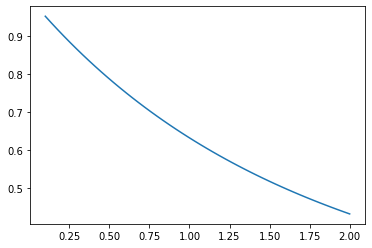

In [54]:
tau = np.linspace(0.1, 2)
beta = oxygen.tau_to_beta(tau)
plt.plot(tau, beta)

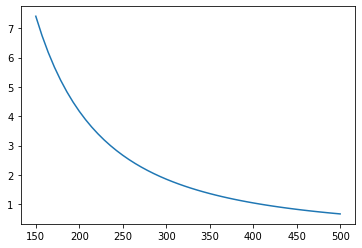

In [55]:
# Evolution of the optical depth of SN1987A
# based on eqn 14.5 (has no number but shortly after eqn 14) from Li+1992
# N_O ~ 6.2e10 t_2^{-3}   where t_2 = t/100d

# from Jerkstrant handbook for O I 6300 line
g_u = 5
g_l = 9

t_grid = np.linspace(150, 500) # days
t_2 = t_grid / 100
t_s = t_grid * 24 * 3600

n_oi = 6.2e10 * t_2**(-3) # cm^-3
lamb = 6300 * u.Angstrom.to(u.cm)
tau = 1/8/np.pi * g_u/g_l * oxygen.RAD_DECAY_RATE_6300 * lamb**3 * n_oi * t_s
plt.plot(t_grid, tau)

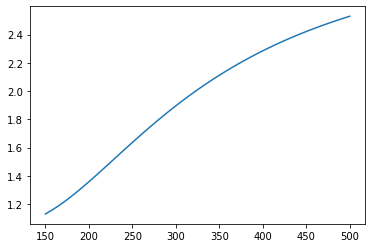

In [56]:
# from Jerkstrant handbook for O I 6300 line
g_u = 5
g_l = 9

t_grid = np.linspace(150, 500) # days
t_2 = t_grid / 100
t_s = t_grid * 24 * 3600

n_oi = 6.2e10 * t_2**(-3) # cm^-3
lamb = 6300 * u.Angstrom.to(u.cm)
tau6300 = 1/8/np.pi * g_u/g_l * oxygen.RAD_DECAY_RATE_6300 * lamb**3 * n_oi * t_s
tau6364 = tau6300/3

# line ratio R
beta_6300 = (1-np.exp(-tau6300))/tau6300
beta_6364 = (1-np.exp(-tau6364))/tau6364
pre6300 = oxygen.LUM_6300_PRE_FACTOR
pre6364 = oxygen.LUM_6364_PRE_FACTOR
R = (beta_6300*pre6300)/(beta_6364*pre6364)
plt.plot(t_grid, R)

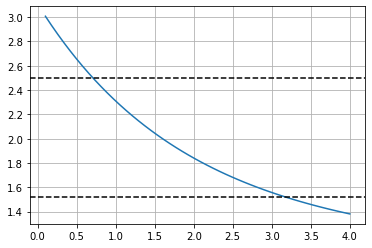

In [10]:
tau6300 = np.linspace(0.1, 4)
tau6364 = tau6300/3

# line ratio R
beta_6300 = (1-np.exp(-tau6300))/tau6300
beta_6364 = (1-np.exp(-tau6364))/tau6364
pre6300 = oxygen.LUM_6300_PRE_FACTOR
pre6364 = oxygen.LUM_6364_PRE_FACTOR
R = (beta_6300*pre6300)/(beta_6364*pre6364)
plt.plot(tau6300, R)
plt.axhline(2.5, ls='--', color='black')
plt.axhline(1.52, ls='--', color='black')
plt.grid()

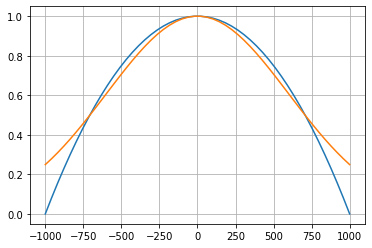

In [11]:
# line profile comparison (2022-06-15)
# Gaussian versus parabolic
v_max = 1000
v = np.linspace(-1000, 1000)
parabolic = 1-(v/v_max)**2

import snelib19odp.gaussian as gaussian
gauss = gaussian.gaussian(v, 0, 1.0, 600)

plt.plot(v, parabolic/np.nanmax(parabolic))
plt.plot(v, gauss/np.nanmax(gauss))
plt.grid()

<ipython-input-57-166586b8c531>:17: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(v_grid, finterp6300/(finterp6364-finterp6364B*remove_ratio), label=label)
<ipython-input-57-166586b8c531>:17: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(v_grid, finterp6300/(finterp6364-finterp6364B*remove_ratio), label=label)
<ipython-input-57-166586b8c531>:17: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(v_grid, finterp6300/(finterp6364-finterp6364B*remove_ratio), label=label)


(0.0, 3.0)

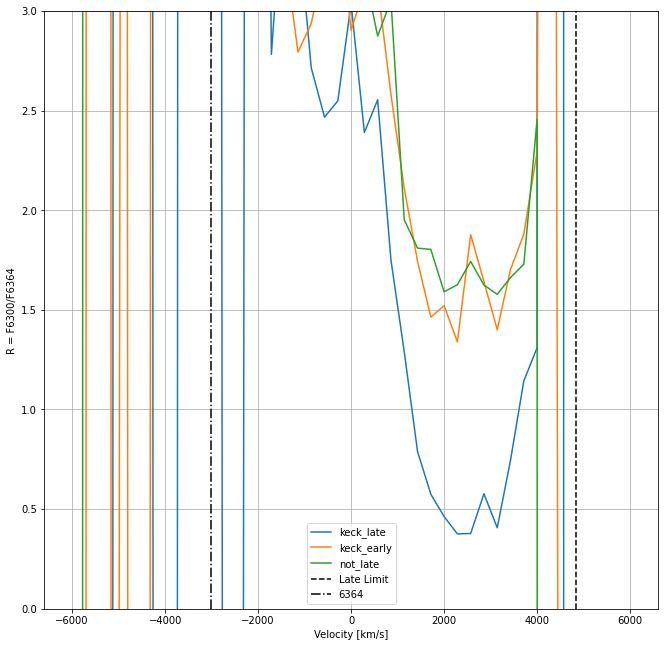

In [57]:
plt.figure(figsize=(11,11))

def ratio_decompose(name, label, continuum=0, remove_ratio=1.0):
    s = sds[name]
    s = s[~np.isnan(s['flux'])]
    idx = np.logical_and(s['restwave'] > 6100, s['restwave'] < 6500)
    s = s[idx]
    s.sort('restwave', reverse=True)
    c = 299792.458
    velocity6300 = (6300/s['restwave']-1)*c
    velocity6364 = (6364/s['restwave']-1)*c
    
    v_grid = np.linspace(-8000,6000)
    finterp6300 = np.interp(v_grid, velocity6300, s['flux']-continuum)
    finterp6364 = np.interp(v_grid, velocity6364, s['flux']-continuum)
    finterp6364B = np.interp(v_grid, velocity6364+3300, s['flux']-continuum)
    plt.plot(v_grid, finterp6300/(finterp6364-finterp6364B*remove_ratio), label=label)
    #plt.plot(v_grid, finterp6300, label=label)
    x = table.Table({'restwave': s['restwave'], 'v6300': velocity6300, 'v6364': velocity6364})
    #print(velocity6300-velocity6364)
    #x.pprint()
ratio_decompose('ZTF19abqwtfu_20200821_Keck1_v1', 'keck_late', continuum=0.3e-17)
ratio_decompose('ZTF19abqwtfu_20200124_Keck1_v1', 'keck_early', continuum=0.5e-16)
ratio_decompose('ZTF19abqwtfu_20200113_NOT_v1', 'not_late', continuum=0.7e-16)

plt.xlabel('Velocity [km/s]')
plt.ylabel('R = F6300/F6364')
c = 299792.458
plt.axvline((6300/6200-1)*c, label='Late Limit', ls='--', color='black')
plt.axvline((6300/6364-1)*c, label='6364', ls='-.', color='black')
plt.legend()
plt.grid()
plt.ylim((0,3))

In [13]:
aconst.c.value/1e3

299792.458

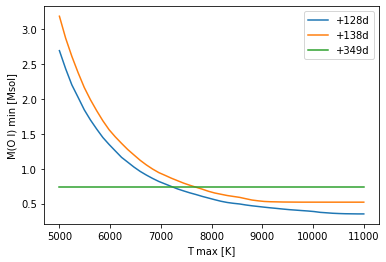

In [58]:
def plot_moi_min(model_name):
    tmax = np.linspace(5000, 11000)
    for specn in SPECS.keys():
        label = ''
        if specn == 'not_late':
            label = '+128d'
        elif specn == 'keck_early':
            label = '+138d'
        elif specn == 'keck_late':
            label = '+349d'
        specmod = make_model(model_name, specn)
        trace_m = extract_trace(specmod, 0)
        trace_t = extract_trace(specmod, 1)
        moi_min = np.empty_like(tmax)
        for i in range(len(tmax)):
            idx = trace_t < tmax[i]
            if np.count_nonzero(idx) > 0:
                moi_min[i] = np.percentile(trace_m[idx], 1)
            else:
                moi_min[i] = np.nan
        plt.plot(tmax, moi_min, label=label)
plot_moi_min('full_multiline_nlte0.01')
plt.xlabel('T max [K]')
plt.ylabel('M(O I) min [Msol]')
plt.legend()
plt.savefig('2022-06-08-oxygen-tmax-moimin.png')

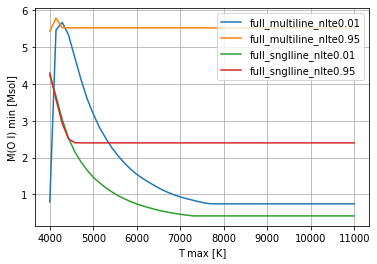

In [59]:
# combined version of above
def plot_moi_min_combined(model_name):
    tmax = np.linspace(4000, 11000)
    moi_mins = []
    for specn in SPECS.keys():
        specmod = make_model(model_name, specn)
        trace_m = extract_trace(specmod, 0)
        trace_t = extract_trace(specmod, 1)
        moi_min = np.empty_like(tmax)
        for i in range(len(tmax)):
            idx = trace_t < tmax[i]
            if np.count_nonzero(idx) > 0:
                moi_min[i] = np.percentile(trace_m[idx], 1)
            else:
                moi_min[i] = np.nan
        moi_mins.append(moi_min)
    moi_min = np.empty_like(tmax)
    for i in range(len(tmax)):
        vals = np.array([smm[i] for smm in moi_mins])
        moi_min[i] = np.nanmax(vals)
    plt.plot(tmax, moi_min, label=model_name)
plot_moi_min_combined('full_multiline_nlte0.01')
plot_moi_min_combined('full_multiline_nlte0.95')
plot_moi_min_combined('full_snglline_nlte0.01')
plot_moi_min_combined('full_snglline_nlte0.95')
plt.xlabel('T max [K]')
plt.ylabel('M(O I) min [Msol]')
plt.legend()
plt.grid()
plt.savefig('2022-06-08-oxygen-tmax-moimin-combined.png')

(<Figure size 547.2x547.2 with 9 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='$x_{2}$'>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:xlabel='$x_{1}$', ylabel='$x_{3}$'>,
         <AxesSubplot:xlabel='$x_{2}$'>, <AxesSubplot:xlabel='$x_{3}$'>]],
       dtype=object))

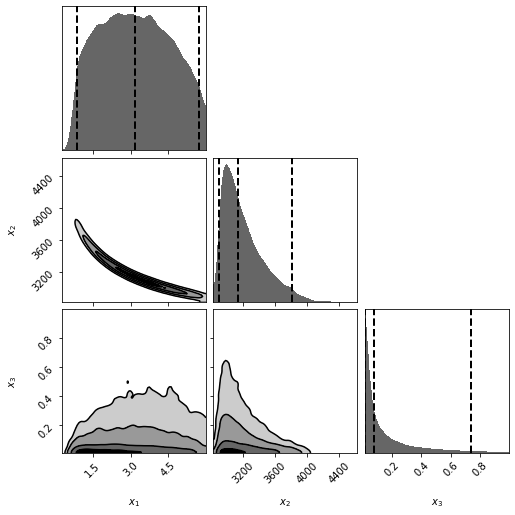

In [16]:
specmod = make_model('full_multiline_nlte0.01', 'keck_late')
specmod.run()
dyplot.cornerplot(specmod.results, dims=[0,1, 11])

(<Figure size 547.2x547.2 with 9 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='$x_{2}$'>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:xlabel='$x_{1}$', ylabel='$x_{3}$'>,
         <AxesSubplot:xlabel='$x_{2}$'>, <AxesSubplot:xlabel='$x_{3}$'>]],
       dtype=object))

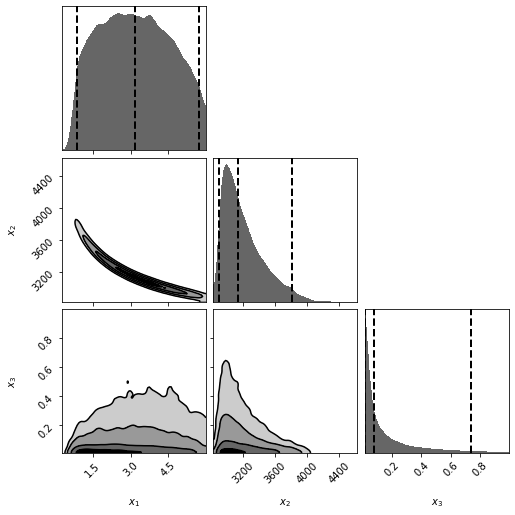

In [17]:
specmod = make_model('full_multiline_nlte0.01', 'keck_late')
specmod.run()
dyplot.cornerplot(specmod.results, dims=[0,1, 11])

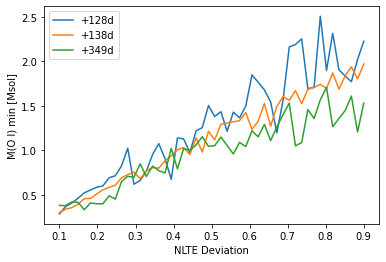

In [62]:
def plot_moi_nlte(model_name):
    nlte = np.linspace(0.1, 0.9)
    for specn in SPECS.keys():
        label = ''
        if specn == 'not_late':
            label = '+128d'
        elif specn == 'keck_early':
            label = '+138d'
        elif specn == 'keck_late':
            label = '+349d'
        specmod = make_model(model_name, specn)
        trace_m = extract_trace(specmod, 0)
        trace_t = extract_trace(specmod, 1)
        trace_nlte = extract_trace(specmod, 11)
        moi_min = np.empty_like(nlte)
        for i in range(len(nlte)):
            #idx = trace_t < tmax[i]
            idx = np.abs(trace_nlte-nlte[i]) < 0.005
            if np.count_nonzero(idx) > 0:
                moi_min[i] = np.percentile(trace_m[idx], 0.1)
            else:
                moi_min[i] = np.nan
        plt.plot(nlte, moi_min, label=label)
#plot_moi_nlte('full_multiline_nlte0.01')
plot_moi_nlte('full_snglline_nlte0.01')
plt.xlabel('NLTE Deviation')
plt.ylabel('M(O I) min [Msol]')
plt.legend()
#plt.savefig('2022-06-08-oxygen-tmax-moimin.png')

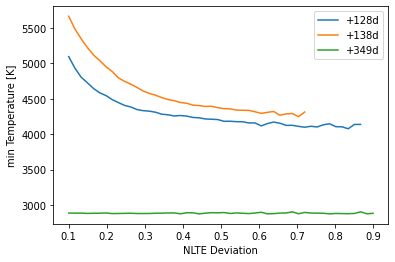

In [60]:
def spec_name_to_label(specn):
    if specn == 'not_late':
        return '+128d'
    elif specn == 'keck_early':
        return '+138d'
    elif specn == 'keck_late':
        return '+349d'
    else:
        return ''

def plot_nlte_temp(model_name):
    nlte = np.linspace(0.1, 0.9)
    for specn in SPECS.keys():
        label = spec_name_to_label(specn)
        
        specmod = make_model(model_name, specn)
        trace_m = extract_trace(specmod, 0)
        trace_t = extract_trace(specmod, 1)
        trace_nlte = extract_trace(specmod, 11)
        t_min = np.empty_like(nlte)
        for i in range(len(nlte)):
            #idx = trace_t < tmax[i]
            idx = np.abs(trace_nlte-nlte[i]) < 0.01
            if np.count_nonzero(idx) > 0:
                t_min[i] = np.percentile(trace_t[idx], 1)
            else:
                t_min[i] = np.nan
        plt.plot(nlte, t_min, label=label)
plot_nlte_temp('full_multiline_nlte0.01')
plt.xlabel('NLTE Deviation')
plt.ylabel('min Temperature [K]')
#plt.ylabel('M(O I) min [Msol]')
plt.legend()
#plt.savefig('2022-06-08-oxygen-tmax-moimin.png')

        model_moi   tau_moi spec epoch
0        3.658577  4.063893      +128d
1        3.588421  7.286957      +128d
2        2.946684  6.743006      +128d
3        5.109634  6.358988      +128d
4        1.150805  6.150598      +128d
...           ...       ...        ...
264862   4.775831  6.071096      +349d
264863   3.054886  6.889342      +349d
264864   1.419932  6.687281      +349d
264865   2.262678  6.424143      +349d
264866   3.673582  6.498630      +349d

[908619 rows x 3 columns]


/home/welterde/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


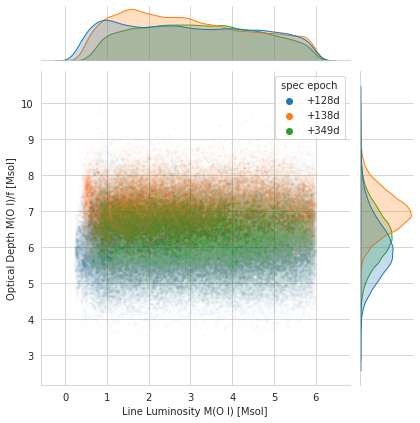

In [20]:
def plot_model_vs_inferred(model_name, fill_factor=0.1, lbl_prefix=''):
    frames = []
    for spec_name in SPECS.keys():
        specmod = make_model(model_name, spec_name)
        spec_time = specmod.spec.meta['obs_mjd'] - 58714.5
        spec_time *= 3600*24
        #print(specmod.spec.meta)
        
        line_velocity = extract_model_line_velocity(specmod)
        tau6300 = extract_model_optical_depth6300(specmod)
        model_moi = extract_model_moi(specmod)
        inferred_moi = tau6300/oxygen.optical_depth_from_line_volume(6300, 1.0, line_velocity, spec_time,fill_factor=fill_factor)
        #plt.scatter(model_moi, inferred_moi, label=lbl_prefix+spec_name)
        frames.append(pd.DataFrame({'model_moi': model_moi, 'tau_moi': inferred_moi, 'spec epoch': spec_name_to_label(spec_name)}))
    df = pd.concat(frames)
    print(df)
    with seaborn.axes_style("whitegrid"):
        #ax = seaborn.jointplot(data=df.iloc[::6, :], x='model_moi', y='tau_moi', hue='spec epoch', kind='kde', thresh=0.1, levels=4, gridsize=50)
        #ax = seaborn.jointplot(data=df, x='model_moi', y='tau_moi', hue='spec epoch', kind='hist', alpha=0.8, stat='density', bins=50, pthresh=0.01, pmax=0.9, common_bins=True, common_norm=True)
        ax = seaborn.jointplot(data=df.iloc[::3], x='model_moi', y='tau_moi', hue='spec epoch', kind='scatter', alpha=0.01, marker='.', joint_kws={'linewidths': 0.1})
        ax.set_axis_labels('Line Luminosity M(O I) [Msol]', 'Optical Depth M(O I)/f [Msol]')
plot_model_vs_inferred('full_multiline_nlte0.01', fill_factor=1.0)
#plt.ylabel('$M(OI)/f$')
#plt.legend()
#plt.savefig('../paper/plots/oxygen/full_multiline_nlte0.01-moi-lum-tau-comparison.png')

        model_moi      model_t spec epoch
0        3.658577  4511.396792      +128d
1        3.588421  4860.864708      +128d
2        2.946684  5111.040889      +128d
3        5.109634  4439.143168      +128d
4        1.150805  6212.945314      +128d
...           ...          ...        ...
264862   4.775831  2963.901740      +349d
264863   3.054886  3163.386386      +349d
264864   1.419932  3535.357558      +349d
264865   2.262678  3288.969715      +349d
264866   3.673582  3077.942877      +349d

[908619 rows x 3 columns]


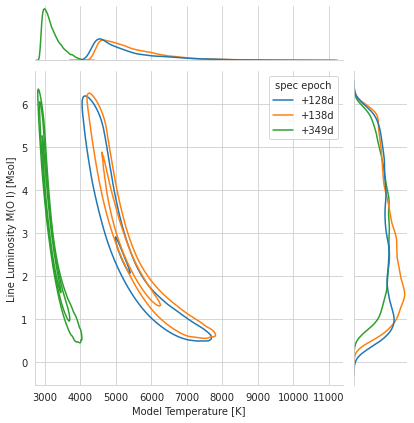

In [21]:
def plot_model_t_moi(model_name):
    frames = []
    for spec_name in SPECS.keys():
        specmod = make_model(model_name, spec_name)
        spec_time = specmod.spec.meta['obs_mjd'] - 58714.5
        spec_time *= 3600*24
        #print(specmod.spec.meta)
        
        model_moi = extract_model_moi(specmod)
        model_t = extract_model_temp(specmod)
        frames.append(pd.DataFrame({'model_moi': model_moi, 'model_t': model_t, 'spec epoch': spec_name_to_label(spec_name)}))
    df = pd.concat(frames)
    print(df)
    with seaborn.axes_style("whitegrid"):
        ax = seaborn.jointplot(data=df.iloc[::5, :], y='model_moi', x='model_t', hue='spec epoch', kind='kde', thresh=0.05, levels=4)
        ax.set_axis_labels('Model Temperature [K]', 'Line Luminosity M(O I) [Msol]')
plot_model_t_moi('full_multiline_nlte0.01')
#plt.savefig('../paper/plots/oxygen/full_multiline_nlte0.01-moi-temp.png')

5989


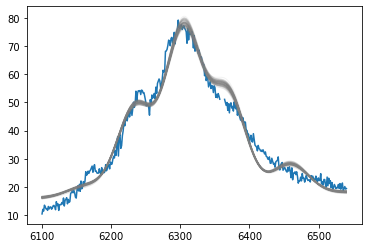

In [12]:
# render the very NLTE models
s_name = 'keck_early'
specmod = make_model('full_multiline_nlte0.01', s_name)
specmod.run()
cfg = specmod.params

spec = SPECS[s_name][0]
idx = np.logical_and(spec['restwave'] > cfg.start6300_6364, spec['restwave'] < cfg.stop6300_6364)
wave = spec['restwave'][idx]
plt.plot(wave, spec[idx]['flux']*cfg.scale_factor)

# now select large nlte deviation
trace = specmod.samples
idx = trace[:,11] < 0.03
print(np.count_nonzero(idx))
trace_s = trace[idx]
for i in np.random.randint(0, np.count_nonzero(idx)-1, size=100):
    p = trace_s[i]
    #print(p.shape)
    f = oxygen.render(cfg=specmod.params, p=p, wave=wave)
    plt.plot(wave, f, alpha=0.1, lw=1, color='grey')

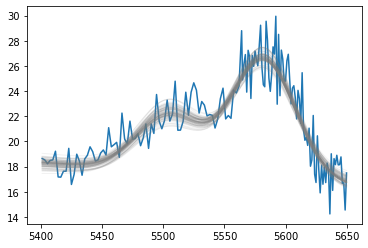

In [15]:
# render the very NLTE models
s_name = 'keck_early'
specmod = make_model('full_multiline_nlte0.01', s_name)
specmod.run()
cfg = specmod.params

spec = SPECS[s_name][0]
idx = np.logical_and(spec['restwave'] > cfg.start5577, spec['restwave'] < cfg.stop5577)
wave = spec['restwave'][idx]
plt.plot(wave, spec[idx]['flux']*cfg.scale_factor)

# now select large nlte deviation
trace = specmod.samples
idx = trace[:,11] < 0.03
trace_s = trace[idx]
for i in np.random.randint(0, np.count_nonzero(idx)-1, size=100):
    p = trace_s[i]
    #print(p.shape)
    f = oxygen.render(cfg=specmod.params, p=p, wave=wave)
    plt.plot(wave, f, alpha=0.1, lw=1, color='grey')

Lum:  2.7138497768058622e+39


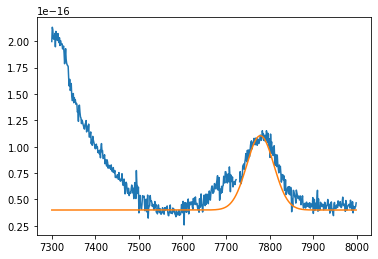

In [35]:
# wrong place here, but estimate the 777x luminosity
s_name = 'keck_early'
specmod = make_model('full_multiline_nlte0.01', s_name)
specmod.run()
cfg = specmod.params

spec = SPECS[s_name][0]
idx = np.logical_and(spec['restwave'] > 7300, spec['restwave'] < 8000)
wave = spec['restwave'][idx]
plt.plot(wave, spec[idx]['flux'])

# estimate median line width
trace = specmod.samples
line_width = np.percentile(trace[:,2], 50)
offset = np.percentile(trace[:,8], 50)

line_flux = 5.5e-15
flux = 0.4e-16 + gaussian.gaussian(wave+offset, 7774, line_flux, line_width*1.2)
plt.plot(wave, flux)

dist_cm, _ = utils.redshift2distance(sds.transient.redshift, sds.transient.redshift)
print('Lum: ', utils.flux2luminosity(line_flux, dist_cm))

Lum:  1.233568080366301e+39


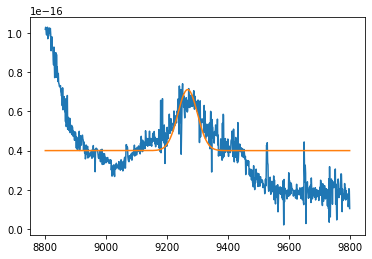

In [47]:
# now lets try the same for 9263
# wrong place here, but estimate the 777x luminosity
s_name = 'keck_early'
specmod = make_model('full_multiline_nlte0.01', s_name)
specmod.run()
cfg = specmod.params

spec = SPECS[s_name][0]
idx = np.logical_and(spec['restwave'] > 8800, spec['restwave'] < 9800)
wave = spec['restwave'][idx]
plt.plot(wave, spec[idx]['flux'])

# estimate median line width
trace = specmod.samples
line_width = np.percentile(trace[:,2], 50)
offset = np.percentile(trace[:,8], 50)

line_flux = 2.5e-15
flux = 0.4e-16 + gaussian.gaussian(wave+offset, 9263, line_flux, 32)
plt.plot(wave, flux)

dist_cm, _ = utils.redshift2distance(sds.transient.redshift, sds.transient.redshift)
print('Lum: ', utils.flux2luminosity(line_flux, dist_cm))

In [40]:
line_width

25.967395769688242